<a href="https://colab.research.google.com/github/tsholofelo-mokheleli/ACIS-2023-New-Zealand/blob/main/Emma_Feature_Selection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Warning filter
import warnings
warnings.filterwarnings('ignore')
cmap=sns.color_palette('Blues_r')

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


# Plot Theme
sns.set_style("darkgrid")
plt.style.use("seaborn-deep")

**Load the Data**

In [15]:
data = pd.read_csv("Diabetes Multi-Class.csv", sep=';', on_bad_lines='skip')

In [16]:
data.shape

(10000, 23)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient               10000 non-null  int64  
 1   Diabetes_012          10000 non-null  float64
 2   HighBP                10000 non-null  float64
 3   HighChol              10000 non-null  float64
 4   CholCheck             10000 non-null  float64
 5   BMI                   10000 non-null  float64
 6   Smoker                10000 non-null  float64
 7   Stroke                10000 non-null  float64
 8   HeartDiseaseorAttack  10000 non-null  float64
 9   PhysActivity          10000 non-null  float64
 10  Fruits                10000 non-null  float64
 11  Veggies               10000 non-null  float64
 12  HvyAlcoholConsump     10000 non-null  float64
 13  AnyHealthcare         10000 non-null  float64
 14  NoDocbcCost           10000 non-null  float64
 15  GenHlth             

In [18]:
data = data.drop(["Patient"], axis=1)
data = data.dropna()

# Convert all columns to int data type
for column in data.columns:
    data[column] = data[column].astype('float')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_012          10000 non-null  float64
 1   HighBP                10000 non-null  float64
 2   HighChol              10000 non-null  float64
 3   CholCheck             10000 non-null  float64
 4   BMI                   10000 non-null  float64
 5   Smoker                10000 non-null  float64
 6   Stroke                10000 non-null  float64
 7   HeartDiseaseorAttack  10000 non-null  float64
 8   PhysActivity          10000 non-null  float64
 9   Fruits                10000 non-null  float64
 10  Veggies               10000 non-null  float64
 11  HvyAlcoholConsump     10000 non-null  float64
 12  AnyHealthcare         10000 non-null  float64
 13  NoDocbcCost           10000 non-null  float64
 14  GenHlth               10000 non-null  float64
 15  MentHlth            

In [19]:
class_counts = data['Diabetes_012'].value_counts()
print(class_counts)

0.0    8216
2.0    1606
1.0     178
Name: Diabetes_012, dtype: int64


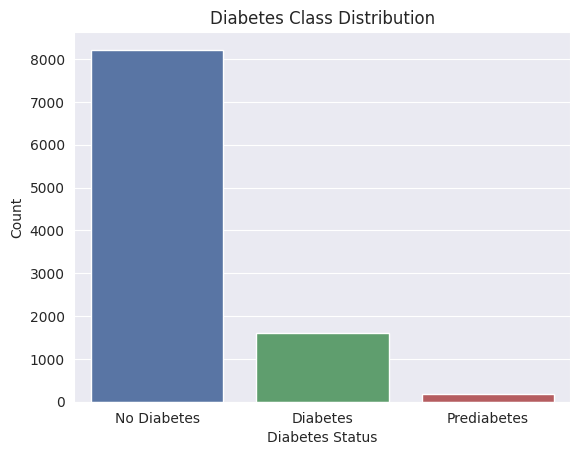

In [20]:
# Create a copy of the original dataset
new_data = data.copy()

mh_mapping = {0.0: 'No Diabetes', 1.0: 'Prediabetes', 2.0: 'Diabetes'}
new_data['dhi_label'] = new_data['Diabetes_012'].map(mh_mapping)

# Plot the distribution based on the new dataset
sns.countplot(data=new_data, x='dhi_label')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.title('Diabetes Class Distribution')
plt.show()

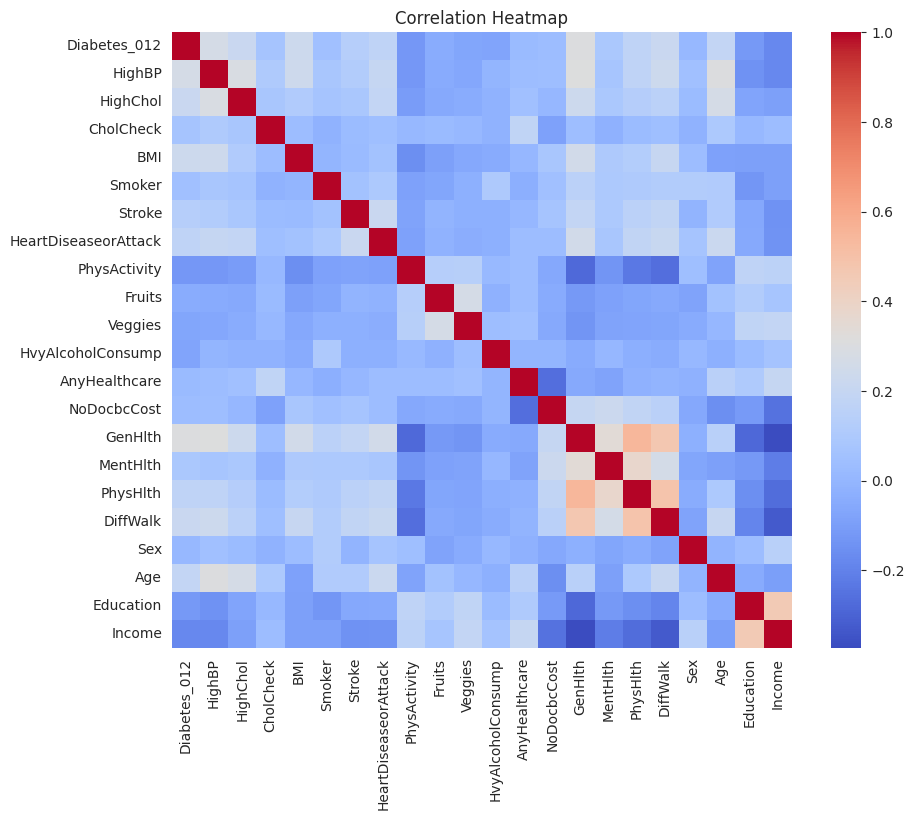

In [21]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [22]:
X = data.drop(["Diabetes_012"], axis=1)
y = data['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
print(X_train.shape)

(8000, 21)


In [24]:
print(X_test.shape)

(2000, 21)


**Baseline Models**

In [25]:
# Define a list of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
}

In [26]:
# Dictionary to store evaluation metrics
results = {}

# Loop through each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=1)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=1)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=1)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    # ROC AUC calculation for binary and multiclass classification
    if len(np.unique(y_train)) == 2:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

    # Store the results in the dictionary
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Balanced Accuracy": balanced_accuracy,
        "Confusion Matrix": confusion,
    }

# Display the results
for name, metrics in results.items():
    print(f"--- {name} ---")
    print("Accuracy: {:.2f}".format(metrics["Accuracy"]))
    print("Precision: {:.2f}".format(metrics["Precision"]))
    print("Recall: {:.2f}".format(metrics["Recall"]))
    print("F1 Score: {:.2f}".format(metrics["F1 Score"]))
    print("ROC AUC: {:.2f}".format(metrics["ROC AUC"]))
    print("Balanced Accuracy: {:.2f}".format(metrics["Balanced Accuracy"]))
    print("Confusion Matrix:")
    print(metrics["Confusion Matrix"])
    print("\n")

--- Logistic Regression ---
Accuracy: 0.83
Precision: 0.79
Recall: 0.83
F1 Score: 0.78
ROC AUC: 0.75
Balanced Accuracy: 0.38
Confusion Matrix:
[[1598    0   45]
 [  31    0    5]
 [ 267    0   54]]


--- Random Forest ---
Accuracy: 0.83
Precision: 0.79
Recall: 0.83
F1 Score: 0.78
ROC AUC: 0.73
Balanced Accuracy: 0.38
Confusion Matrix:
[[1601    0   42]
 [  31    0    5]
 [ 271    0   50]]


--- K-Nearest Neighbors ---
Accuracy: 0.80
Precision: 0.74
Recall: 0.80
F1 Score: 0.76
ROC AUC: 0.65
Balanced Accuracy: 0.37
Confusion Matrix:
[[1535    1  107]
 [  28    0    8]
 [ 263    0   58]]


--- XGBoost ---
Accuracy: 0.82
Precision: 0.79
Recall: 0.82
F1 Score: 0.80
ROC AUC: 0.75
Balanced Accuracy: 0.41
Confusion Matrix:
[[1567    0   76]
 [  27    1    8]
 [ 239    1   81]]




**Recursive Feature Elimination with Cross-Validation**

In [28]:
X = data.drop(["Diabetes_012"], axis=1)
y = data['Diabetes_012']

In [29]:
# Define the machine learning model
model = XGBClassifier()

# Define the number of cross-validation folds
cv = StratifiedKFold(n_splits=5)

# Instantiate the RFECV object
rfecv = RFECV(estimator=model, cv=cv)

In [30]:
# Perform feature selection
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))

In [31]:
# Get the selected features
selected_features = X.columns[rfecv.support_]

In [32]:
# Get the optimal number of features
optimal_num_features = rfecv.n_features_

In [33]:
# Print the optimal number of features
print("Optimal Number of Features:", optimal_num_features)

features_selected = []
# Print the selected features
print("Selected Features:")
for feature in selected_features:
  features_selected.append(feature)
  print(f"'{feature}',")

Optimal Number of Features: 1
Selected Features:
'HighBP',


**Train and test the model with the updated features**

In [34]:
data_x = data.drop(["Diabetes_012"], axis=1)
data_y = data['Diabetes_012']

# find intersection between columns in DataFrame and ImportanceFeatures
intersection = set(features_selected).intersection(data_x.columns)

# drop columns not in intersection
data_x = data_x.drop(columns=set(data_x.columns) - intersection)

print(data_x.shape)

# Concatenate the df and Target
data_train = pd.concat([data_x, data_y], axis=1)

data_train.head()

(10000, 1)


,HighBP,Diabetes_012
0,1.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [35]:
X = data_x
y = data_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
# Dictionary to store evaluation metrics
results = {}

# Loop through each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=1)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=1)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=1)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    # ROC AUC calculation for binary and multiclass classification
    if len(np.unique(y_train)) == 2:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

    # Store the results in the dictionary
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Balanced Accuracy": balanced_accuracy,
        "Confusion Matrix": confusion,
    }

# Display the results
for name, metrics in results.items():
    print(f"--- {name} ---")
    print("Accuracy: {:.2f}".format(metrics["Accuracy"]))
    print("Precision: {:.2f}".format(metrics["Precision"]))
    print("Recall: {:.2f}".format(metrics["Recall"]))
    print("F1 Score: {:.2f}".format(metrics["F1 Score"]))
    print("ROC AUC: {:.2f}".format(metrics["ROC AUC"]))
    print("Balanced Accuracy: {:.2f}".format(metrics["Balanced Accuracy"]))
    print("Confusion Matrix:")
    print(metrics["Confusion Matrix"])
    print("\n")

--- Logistic Regression ---
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1 Score: 0.74
ROC AUC: 0.65
Balanced Accuracy: 0.33
Confusion Matrix:
[[1643    0    0]
 [  36    0    0]
 [ 321    0    0]]


--- Random Forest ---
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1 Score: 0.74
ROC AUC: 0.65
Balanced Accuracy: 0.33
Confusion Matrix:
[[1643    0    0]
 [  36    0    0]
 [ 321    0    0]]


--- K-Nearest Neighbors ---
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1 Score: 0.74
ROC AUC: 0.50
Balanced Accuracy: 0.33
Confusion Matrix:
[[1643    0    0]
 [  36    0    0]
 [ 321    0    0]]


--- XGBoost ---
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1 Score: 0.74
ROC AUC: 0.65
Balanced Accuracy: 0.33
Confusion Matrix:
[[1643    0    0]
 [  36    0    0]
 [ 321    0    0]]


